##### Load packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import time

# Set pandas view options
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# filter warnings messages from the notebook
import warnings
warnings.filterwarnings('ignore')

from matminer.datasets.dataset_retrieval import load_dataset
## Generate magpie features
from matminer.featurizers.composition import ElementProperty
from pymatgen import MPRester, Composition
mpr = MPRester('68rWEneaZFyIaKh15uKr') # provide your API key here or add it to pymatgen

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing

# Process Data

##### Load data

In [2]:
# load experimental dataset
data = load_dataset('expt_gap')

#clean up the dataframe, some weird formula
data = data[data.formula != 'GaAs0.1P0.9G1128']

#get theory data from MP given compositons
bandgap_info = pickle.load(open('bandgap_by_formula.pkl', 'rb'))

# Combine theory and experiment
bandgap_df = pd.DataFrame([[key]+value for key, value in bandgap_info.items()], 
                          columns=['formula', 'reduced_formula', 'gap theory'])
grouped_final_data = pd.merge(data, bandgap_df, on='formula').drop(columns=['formula']).dropna() 
final_data = grouped_final_data.sort_values(by=['reduced_formula']).reset_index(drop=True)

# featurize the data with magpie features applied on compositions
final_data['composition'] = final_data['reduced_formula'].apply(Composition)
featurizer = ElementProperty.from_preset("magpie")
featurized_data = featurizer.featurize_dataframe(final_data, 'composition')

featurized_data.head(2)

,gap expt,reduced_formula,gap theory,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum AtomicWeight,MagpieData maximum AtomicWeight,MagpieData range AtomicWeight,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData mode AtomicWeight,MagpieData minimum MeltingT,MagpieData maximum MeltingT,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData mode MeltingT,MagpieData minimum Column,MagpieData maximum Column,MagpieData range Column,MagpieData mean Column,MagpieData avg_dev Column,MagpieData mode Column,MagpieData minimum Row,MagpieData maximum Row,MagpieData range Row,MagpieData mean Row,MagpieData avg_dev Row,MagpieData mode Row,MagpieData minimum CovalentRadius,MagpieData maximum CovalentRadius,MagpieData range CovalentRadius,MagpieData mean CovalentRadius,MagpieData avg_dev CovalentRadius,MagpieData mode CovalentRadius,MagpieData minimum Electronegativity,MagpieData maximum Electronegativity,MagpieData range Electronegativity,MagpieData mean Electronegativity,MagpieData avg_dev Electronegativity,MagpieData mode Electronegativity,MagpieData minimum NsValence,MagpieData maximum NsValence,MagpieData range NsValence,MagpieData mean NsValence,MagpieData avg_dev NsValence,MagpieData mode NsValence,MagpieData minimum NpValence,MagpieData maximum NpValence,MagpieData range NpValence,MagpieData mean NpValence,MagpieData avg_dev NpValence,MagpieData mode NpValence,MagpieData minimum NdValence,MagpieData maximum NdValence,MagpieData range NdValence,MagpieData mean NdValence,MagpieData avg_dev NdValence,MagpieData mode NdValence,MagpieData minimum NfValence,MagpieData maximum NfValence,MagpieData range NfValence,MagpieData mean NfValence,MagpieData avg_dev NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData maximum NValence,MagpieData range NValence,MagpieData mean NValence,MagpieData avg_dev NValence,MagpieData mode NValence,MagpieData minimum NsUnfilled,MagpieData maximum NsUnfilled,MagpieData range NsUnfilled,MagpieData mean NsUnfilled,MagpieData avg_dev NsUnfilled,MagpieData mode NsUnfilled,MagpieData minimum NpUnfilled,MagpieData maximum NpUnfilled,MagpieData range NpUnfilled,MagpieData mean NpUnfilled,MagpieData avg_dev NpUnfilled,MagpieData mode NpUnfilled,MagpieData minimum NdUnfilled,MagpieData maximum NdUnfilled,MagpieData range NdUnfilled,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData mode NdUnfilled,MagpieData minimum NfUnfilled,MagpieData maximum NfUnfilled,MagpieData range NfUnfilled,MagpieData mean NfUnfilled,MagpieData avg_dev NfUnfilled,MagpieData mode NfUnfilled,MagpieData minimum NUnfilled,MagpieData maximum NUnfilled,MagpieData range NUnfilled,MagpieData mean NUnfilled,MagpieData avg_dev NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSvolume_pa,MagpieData maximum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mode GSvolume_pa,MagpieData minimum GSbandgap,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mode GSbandgap,MagpieData minimum GSmagmom,MagpieData maximum GSmagmom,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,0.0,Ag(AuS)2,0.0,"(Ag, Au, S)",16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,88.0,23.0,74.6,10.720000,66.0,32.065,196.966569,164.901569,113.186268,67.024241,32.065,388.36,1337.33

In [3]:
print('we have {} total data.'.format(featurized_data.shape[0]))

training_df, test_df = train_test_split(featurized_data, test_size=0.2, random_state=42)

print('{} of which will be test data.'.format(test_df.shape[0]))

we have 5216 total data.
1044 of which will be test data.


# Machine Learning Algorithm Selection 

In [5]:
## helper function 
def get_features_from_df(df, label=None):
    """
    Helper function to get features of dataframe
    
    Args:
    label    1 if the data is experimental data,  0 if the data is theory data. 
    """
    magpie_columns = [column for column in df if column.startswith("MagpieData")]
    feature_df = df[magpie_columns] 
    feature_df['expt_calculated'] = label
    return feature_df

In [6]:
# sub_training_df = training_df.sample(n=3, random_state=42)
# exp_df = get_features_from_df(sub_training_df, 1)
# theory_df = get_features_from_df(sub_training_df, 0)

100 training data is used


<Figure size 720x360 with 0 Axes>

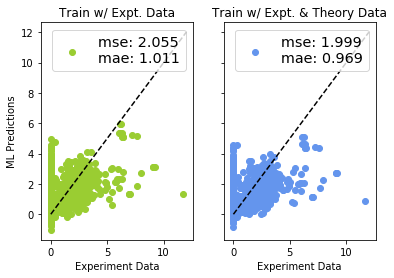

250 training data is used


<Figure size 720x360 with 0 Axes>

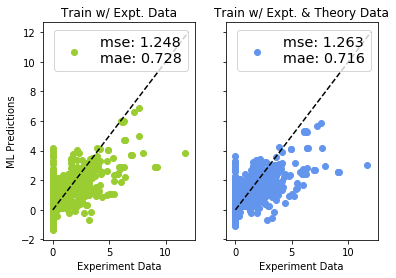

500 training data is used


<Figure size 720x360 with 0 Axes>

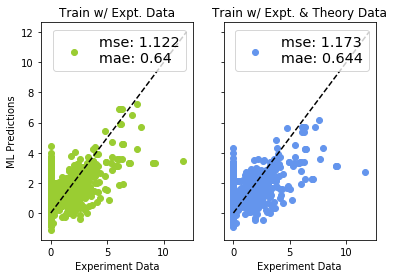

1000 training data is used


<Figure size 720x360 with 0 Axes>

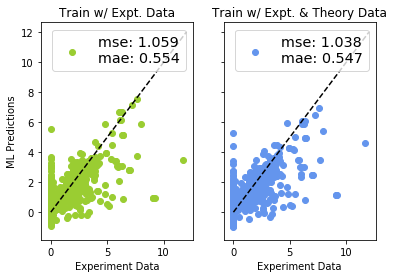

1500 training data is used


<Figure size 720x360 with 0 Axes>

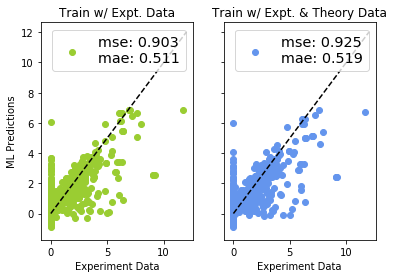

2000 training data is used


<Figure size 720x360 with 0 Axes>

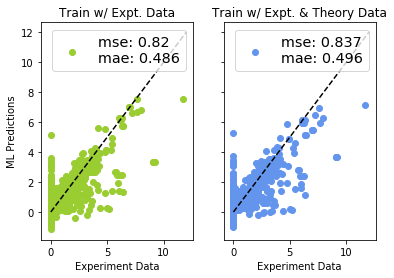

3000 training data is used


<Figure size 720x360 with 0 Axes>

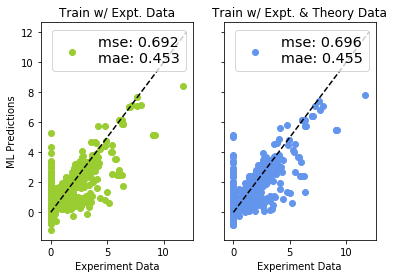

4172 training data is used


<Figure size 720x360 with 0 Axes>

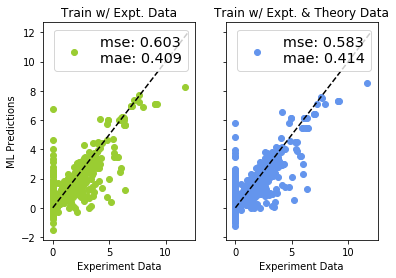

In [9]:
# label is 1 because we will only test on expt data
test_X = get_features_from_df(test_df, label=1).values.tolist()

# Sample various fraction of the total training data 
# -----------------------------------------------------------------
subsets = [100, 250, 500, 1000, 1500, 2000, 3000, training_df.shape[0]]
for n in subsets:
    sub_training_df = training_df.sample(n=n, random_state=42)
    
    # Just Experimental Data 
    # ----------------------------------------------------------------
    scaler1 = preprocessing.StandardScaler()
    training_X1 = get_features_from_df(sub_training_df, label=1).values.tolist()
    training_X1 = scaler1.fit_transform(training_X1)
    training_y1 = np.array(sub_training_df[['gap expt']])
    
    svr1 = SVR(C=10)
    svr1.fit(training_X1, training_y1)
    
    test_X1 = scaler1.transform(test_X)
    test_prediction1 = svr1.predict(test_X1)
    
    mse1 = metrics.mean_squared_error(test_df['gap expt'], test_prediction1)    
    mae1 = metrics.mean_absolute_error(test_df['gap expt'], test_prediction1) 

    # Add the DFT data as additional training data
    # ----------------------------------------------------------------
    scaler2 = preprocessing.StandardScaler()
    exp_df = get_features_from_df(sub_training_df, label=1)
    theory_df = get_features_from_df(sub_training_df, label=0)
    
    training_X2 = pd.concat([exp_df, theory_df]).values.tolist()
    training_X2 = scaler2.fit_transform(training_X2)
    
    training_y2 = np.append(list(sub_training_df['gap expt']), 
                           list(sub_training_df['gap theory'])).reshape(-1,1)
    
    svr2 = SVR(C=10)
    svr2.fit(training_X2, training_y2)
    
    test_X2 = scaler2.transform(test_X)
    test_prediction2 = svr2.predict(test_X2)
    
    mse2 = metrics.mean_squared_error(test_df['gap expt'], test_prediction2)
    mae2 = metrics.mean_absolute_error(test_df['gap expt'], test_prediction2) 
    
    # Make plots side-by-side to check prediction errors
    #---------------------------------------------------------------------
    print("{} training data is used".format(n))
    plt.figure(figsize=(10,5))
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

    axs[0].scatter(test_df['gap expt'], test_prediction1, c='yellowgreen',
                    label='mse: {}\nmae: {}'.format(round(mse1,3), round(mae1,3)))
    axs[0].plot([0,12], [0,12], 'k--')
    axs[0].set_title('Train w/ Expt. Data')
    axs[0].legend(fontsize='x-large')


    axs[1]. scatter(test_df['gap expt'], test_prediction2, c='cornflowerblue',
                    label='mse: {}\nmae: {}'.format(round(mse2,3), round(mae2,3)))
    axs[1].plot([0,12], [0,12], 'k--')
    axs[1].set_title('Train w/ Expt. & Theory Data')
    axs[1].legend(fontsize='x-large')

    # Set common labels
    axs[0].set_xlabel('Experiment Data')
    axs[1].set_xlabel('Experiment Data')
    axs[0].set_ylabel('ML Predictions')
    
    plt.show()